# Hybrid Model Training Notebook
## Combining MobileNetV2 + DenseNet121
## Phase 1: Initial Training (Frozen Backbones)
## Phase 2: Fine-tuning (Unfrozen Layers)


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# CELL 1: INSTALL SEABORN AND IMPORT ALL NECESSARY LIBRARIES

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.13.0
GPU Available: []


# CELL 2: DATASET EXPLORATION WITH CLASS DISTRIBUTION ANALYSIS

In [3]:
dataset_path = r"D:\Datasets\skin_dataset\Skin_Conditions"

class_names = os.listdir(dataset_path)
class_names = [name for name in class_names if os.path.isdir(os.path.join(dataset_path, name))]
class_names.sort()
num_classes = len(class_names)

print(f"Found {num_classes} classes:")
class_counts = []
for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_counts.append(num_images)
    print(f"{i}: {class_name} - {num_images} images")

class_labels = np.arange(num_classes)
class_weights = compute_class_weight(
    'balanced',
    classes=class_labels,
    y=np.repeat(class_labels, class_counts)
)

class_weight_dict = dict(zip(class_labels, class_weights))
print(f"\nClass weight dictionary: {class_weight_dict}")

Found 6 classes:
0: Acne - 399 images
1: Carcinoma - 399 images
2: Eczema - 399 images
3: Keratosis - 399 images
4: Milia - 399 images
5: Rosacea - 399 images

Class weight dictionary: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}


# CELL 3: DATA GENERATORS - BALANCED AUGMENTATION

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

# More balanced augmentation - not too aggressive
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 1920 images belonging to 6 classes.
Found 474 images belonging to 6 classes.
Training samples: 1920
Validation samples: 474


# CELL 4: HYBRID ARCHITECTURE WITH FEATURE FUSION

In [5]:
def create_improved_hybrid_model(num_classes):
    input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
   
    # MobileNetV2 - efficient feature extraction
    mobilenet_base = MobileNetV2(
        input_tensor=input_layer,
        weights='imagenet',
        include_top=False,
        alpha=1.4
    )
    mobilenet_base.trainable = False
   
    # MobileNet features with attention
    mob_gap = layers.GlobalAveragePooling2D()(mobilenet_base.output)
    mob_gmp = layers.GlobalMaxPooling2D()(mobilenet_base.output)
    mob_features = layers.Concatenate()([mob_gap, mob_gmp])
   
    # DenseNet121 - dense connectivity
    densenet_base = DenseNet121(
        input_tensor=input_layer,
        weights='imagenet',
        include_top=False
    )
    densenet_base.trainable = False
   
    # DenseNet features with attention
    dense_gap = layers.GlobalAveragePooling2D()(densenet_base.output)
    dense_gmp = layers.GlobalMaxPooling2D()(densenet_base.output)
    dense_features = layers.Concatenate()([dense_gap, dense_gmp])
   
    # IMPROVED: Weighted feature fusion with learnable weights
    mob_weight = layers.Dense(1, activation='sigmoid', name='mob_attention')(mob_features)
    dense_weight = layers.Dense(1, activation='sigmoid', name='dense_attention')(dense_features)
   
    mob_weighted = layers.Multiply()([mob_features, mob_weight])
    dense_weighted = layers.Multiply()([dense_features, dense_weight])
   
    # Combine weighted features
    combined = layers.Concatenate()([mob_weighted, dense_weighted])
    combined = layers.Dropout(0.4)(combined)
   
    # IMPROVED: Deeper classification head with skip connections
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005))(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
   
    # Skip connection
    skip = layers.Dense(256, activation='relu')(x)
   
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip])
    x = layers.Dropout(0.4)(x)
   
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
   
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='he_normal',
        name='output'
    )(x)
   
    model = keras.Model(inputs=input_layer, outputs=outputs, name='Improved_Hybrid')
    return model, mobilenet_base, densenet_base

model, mobilenet_base, densenet_base = create_improved_hybrid_model(num_classes)
print(f"Total parameters: {model.count_params():,}")
model.summary()

Total parameters: 14,590,856
Model: "Improved_Hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)      

# CELL 5: COMPILATION WITH LABEL SMOOTHING LOSS

In [6]:
def label_smoothing_loss(y_true, y_pred, smoothing=0.1):
    """Label smoothing for better generalization"""
    num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
    y_true_smooth = y_true * (1 - smoothing) + (smoothing / num_classes)
    return keras.losses.categorical_crossentropy(y_true_smooth, y_pred)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=label_smoothing_loss,
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled with label smoothing!")

Model compiled with label smoothing!


# CELL 6: CALLBACKS WITH BETTER SCHEDULING

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_enhanced_hybrid_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("Callbacks configured!")

Callbacks configured!


# CELL 7: INITIAL TRAINING WITH FROZEN BASES

In [8]:
EPOCHS_FROZEN = 30

print("Starting initial training...")
history_frozen = model.fit(
    train_generator,
    epochs=EPOCHS_FROZEN,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"Best validation accuracy: {max(history_frozen.history['val_accuracy']):.4f}")

Starting initial training...
Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 2.7564 - accuracy: 0.3083 - top_3_accuracy: 0.6687 - precision: 0.3737 - recall: 0.2026
Epoch 1: val_accuracy improved from -inf to 0.47468, saving model to best_enhanced_hybrid_model.h5
60/60 [==============================] - 148s 2s/step - loss: 2.7564 - accuracy: 0.3083 - top_3_accuracy: 0.6687 - precision: 0.3737 - recall: 0.2026 - val_loss: 3.0327 - val_accuracy: 0.4747 - val_top_3_accuracy: 0.7025 - val_precision: 0.5294 - val_recall: 0.4367 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 2.1508 - accuracy: 0.4948 - top_3_accuracy: 0.8240 - precision: 0.6104 - recall: 0.3656
Epoch 2: val_accuracy improved from 0.47468 to 0.60338, saving model to best_enhanced_hybrid_model.h5
60/60 [==============================] - 155s 3s/step - loss: 2.1508 - accuracy: 0.4948 - top_3_accuracy: 0.8240 - precision: 0.6104 - recall: 0.3656 - val_loss: 2.0362 - val_accu

# CELL 8: FINE-TUNING STRATEGY - GRADUAL UNFREEZING

In [9]:
mobilenet_base.trainable = True
densenet_base.trainable = True

# Unfreeze more layers gradually
for layer in mobilenet_base.layers[:-50]:
    layer.trainable = False

for layer in densenet_base.layers[:-80]:
    layer.trainable = False

print(f"MobileNet trainable: {sum([l.trainable for l in mobilenet_base.layers])}")
print(f"DenseNet trainable: {sum([l.trainable for l in densenet_base.layers])}")

# IMPROVED: Lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,
        clipnorm=1.0
    ),
    loss=label_smoothing_loss,
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("Fine-tuning configured!")

MobileNet trainable: 50
DenseNet trainable: 80
Fine-tuning configured!


# CELL 9: FINE-TUNING WITH IMPROVED SETTINGS

In [10]:
EPOCHS_FINE = 25

fine_tune_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        'best_enhanced_hybrid_finetuned.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("Starting fine-tuning...")
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS_FINE,
    validation_data=val_generator,
    callbacks=fine_tune_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

final_val_acc = max(history_fine.history['val_accuracy'])
print(f"\nFinal validation accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

Starting fine-tuning...
Epoch 1/25
60/60 [==============================] - ETA: 0s - loss: 1.2888 - accuracy: 0.7161 - top_k_categorical_accuracy: 0.9411 - precision: 0.8261 - recall: 0.5865
Epoch 1: val_accuracy improved from -inf to 0.82700, saving model to best_enhanced_hybrid_finetuned.h5
60/60 [==============================] - 261s 4s/step - loss: 1.2888 - accuracy: 0.7161 - top_k_categorical_accuracy: 0.9411 - precision: 0.8261 - recall: 0.5865 - val_loss: 1.0601 - val_accuracy: 0.8270 - val_top_k_categorical_accuracy: 0.9768 - val_precision: 0.9032 - val_recall: 0.7679 - lr: 1.0000e-04
Epoch 2/25
60/60 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.7651 - top_k_categorical_accuracy: 0.9536 - precision: 0.8792 - recall: 0.6370
Epoch 2: val_accuracy improved from 0.82700 to 0.84388, saving model to best_enhanced_hybrid_finetuned.h5
60/60 [==============================] - 234s 4s/step - loss: 1.1795 - accuracy: 0.7651 - top_k_categorical_accuracy: 0.9536

# CELL 10: VISUALIZATION

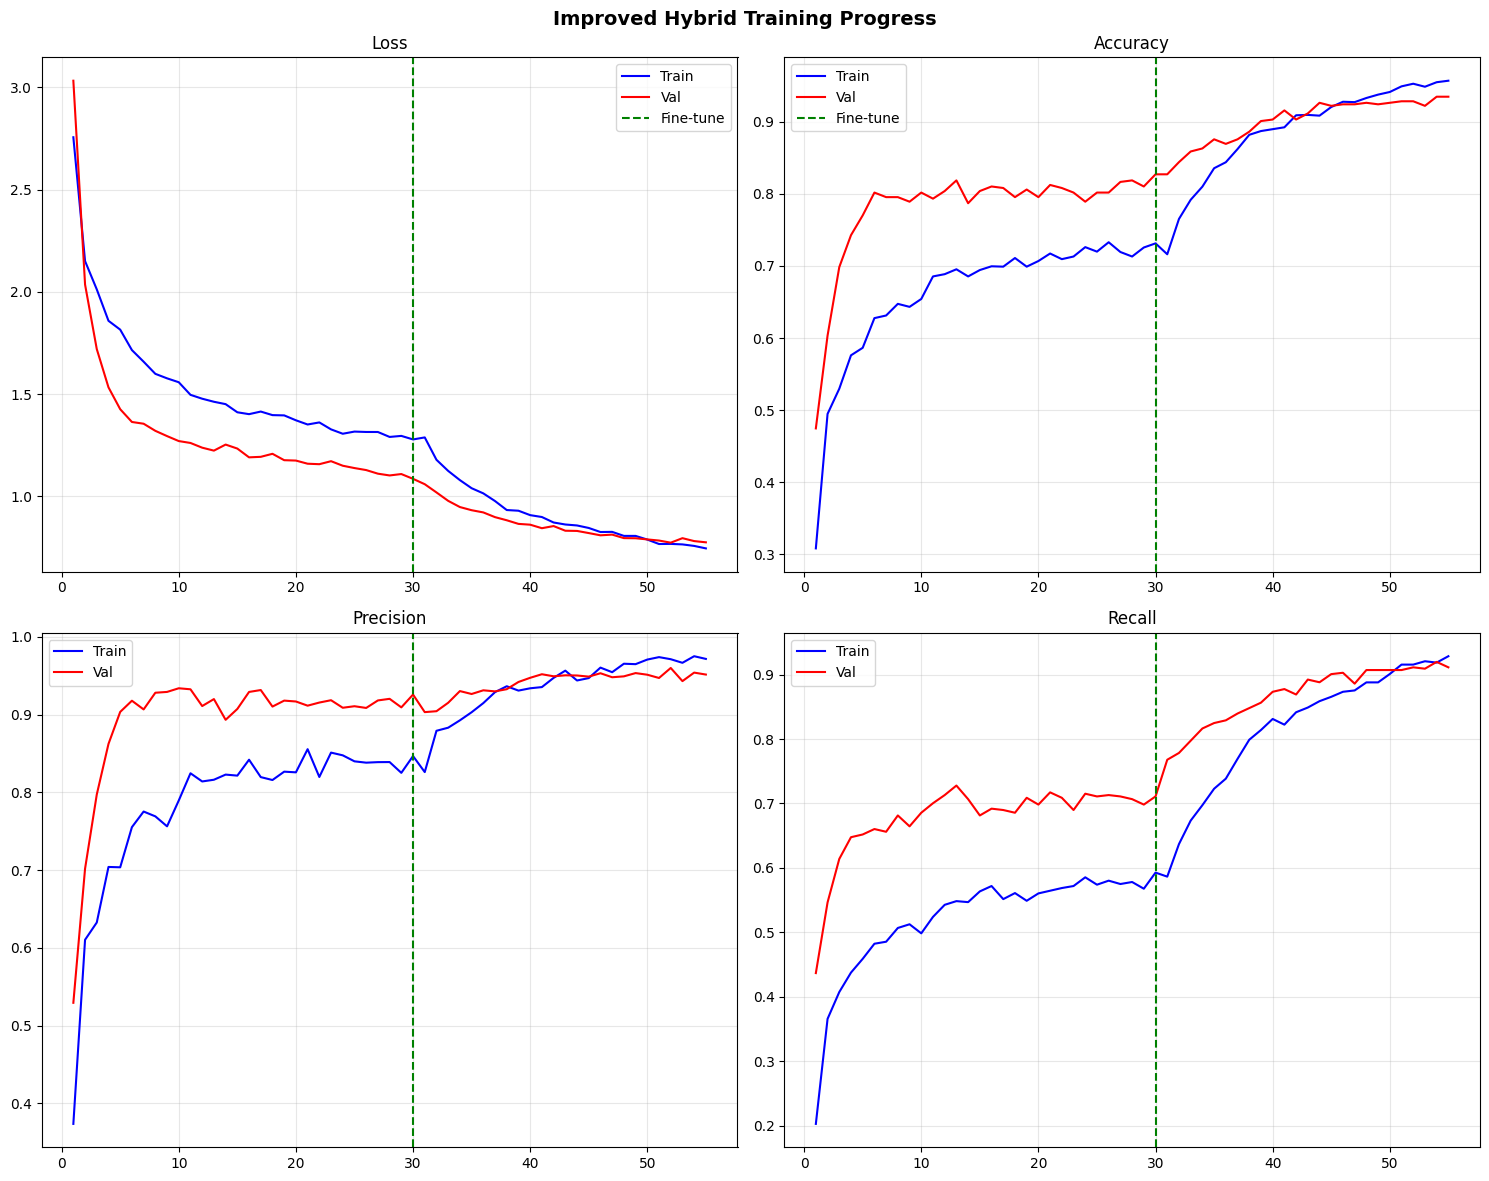

In [11]:
def plot_training(hist1, hist2):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
   
    epochs1 = len(hist1.history['loss'])
    epochs2 = len(hist2.history['loss'])
   
    combined = {
        'loss': hist1.history['loss'] + hist2.history['loss'],
        'val_loss': hist1.history['val_loss'] + hist2.history['val_loss'],
        'accuracy': hist1.history['accuracy'] + hist2.history['accuracy'],
        'val_accuracy': hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    }
   
    epochs = range(1, epochs1 + epochs2 + 1)
   
    # Loss
    axes[0, 0].plot(epochs, combined['loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, combined['val_loss'], 'r-', label='Val')
    axes[0, 0].axvline(epochs1, color='g', linestyle='--', label='Fine-tune')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
   
    # Accuracy
    axes[0, 1].plot(epochs, combined['accuracy'], 'b-', label='Train')
    axes[0, 1].plot(epochs, combined['val_accuracy'], 'r-', label='Val')
    axes[0, 1].axvline(epochs1, color='g', linestyle='--', label='Fine-tune')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
   
    # Precision
    if 'precision' in hist1.history:
        prec = hist1.history['precision'] + hist2.history['precision']
        val_prec = hist1.history['val_precision'] + hist2.history['val_precision']
        axes[1, 0].plot(epochs, prec, 'b-', label='Train')
        axes[1, 0].plot(epochs, val_prec, 'r-', label='Val')
        axes[1, 0].axvline(epochs1, color='g', linestyle='--')
        axes[1, 0].set_title('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
   
    # Recall
    if 'recall' in hist1.history:
        rec = hist1.history['recall'] + hist2.history['recall']
        val_rec = hist1.history['val_recall'] + hist2.history['val_recall']
        axes[1, 1].plot(epochs, rec, 'b-', label='Train')
        axes[1, 1].plot(epochs, val_rec, 'r-', label='Val')
        axes[1, 1].axvline(epochs1, color='g', linestyle='--')
        axes[1, 1].set_title('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
   
    plt.suptitle('Improved Hybrid Training Progress', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training(history_frozen, history_fine)

# CELL 11: COMPREHENSIVE EVALUATION

In [12]:
print("Evaluating model...")

try:
    best_model = keras.models.load_model('best_enhanced_hybrid_finetuned.h5',
                                        custom_objects={'label_smoothing_loss': label_smoothing_loss})
except:
    best_model = model

val_generator.reset()
results = best_model.evaluate(val_generator, verbose=1)
print(f"\nFinal Results: {dict(zip(best_model.metrics_names, results))}")

# Predictions
val_generator.reset()
predictions = best_model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

Evaluating model...
15/15 [==============================] - 35s 2s/step - loss: 0.7820 - accuracy: 0.9346 - top_k_categorical_accuracy: 0.9937 - precision: 0.9540 - recall: 0.9198

Final Results: {'loss': 0.7819843292236328, 'accuracy': 0.9345991611480713, 'top_k_categorical_accuracy': 0.9936708807945251, 'precision': 0.9540481567382812, 'recall': 0.9198312163352966}
15/15 [==============================] - 35s 2s/step

Classification Report:
              precision    recall  f1-score   support

        Acne     0.8810    0.9367    0.9080        79
   Carcinoma     0.9872    0.9747    0.9809        79
      Eczema     0.9394    0.7848    0.8552        79
   Keratosis     0.9875    1.0000    0.9937        79
       Milia     0.9630    0.9873    0.9750        79
     Rosacea     0.8588    0.9241    0.8902        79

    accuracy                         0.9346       474
   macro avg     0.9361    0.9346    0.9338       474
weighted avg     0.9361    0.9346    0.9338       474



# CELL 12: CONFUSION MATRIX AND METRICS TABLE

✓ Confusion matrix saved as 'confusion_matrix_hybrid.png'


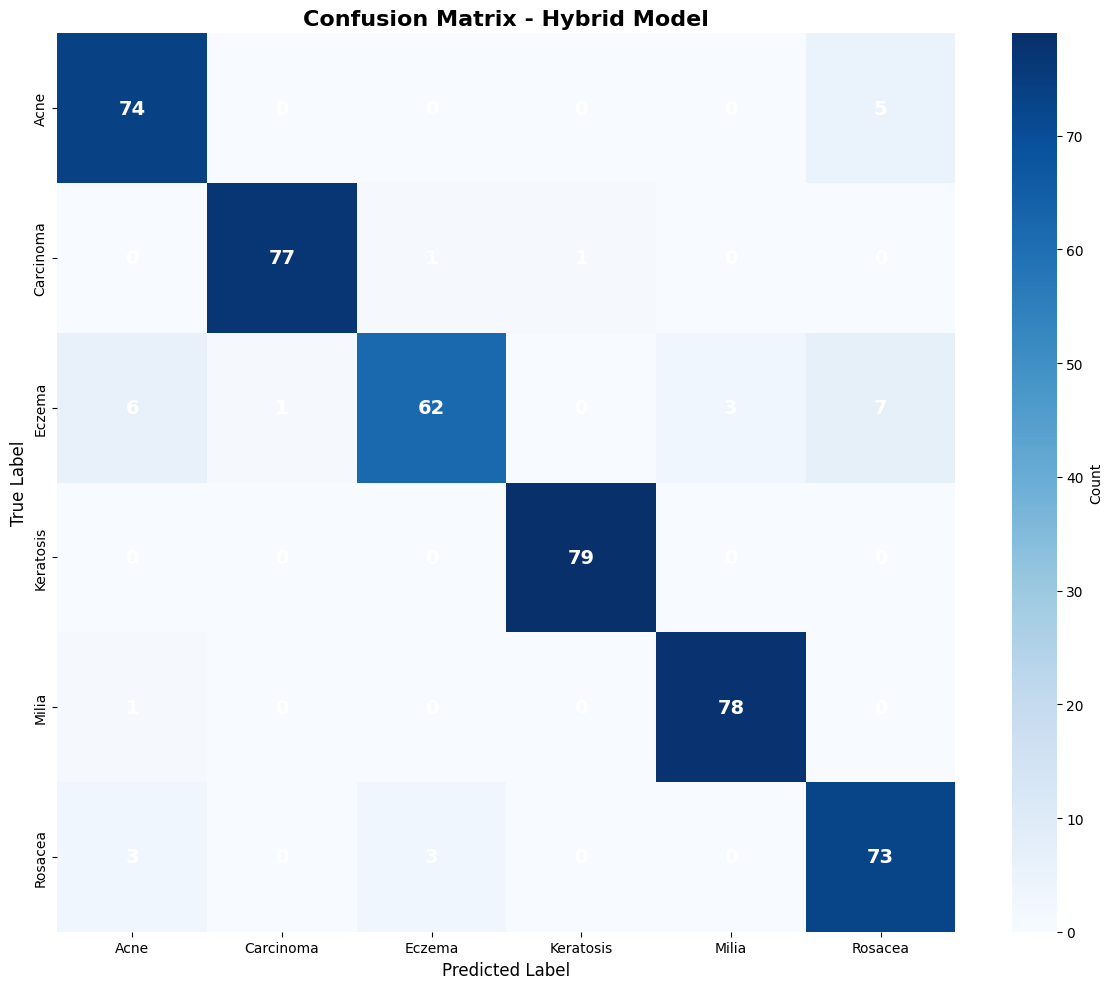


Final Accuracy: 0.9346

========== MODEL PERFORMANCE TABLE ==========
                 Class  Precision  Recall  F1-Score
0                 Acne     0.8810  0.9367    0.9080
1            Carcinoma     0.9872  0.9747    0.9809
2               Eczema     0.9394  0.7848    0.8552
3            Keratosis     0.9875  1.0000    0.9937
4                Milia     0.9630  0.9873    0.9750
5              Rosacea     0.8588  0.9241    0.8902
6  Overall (Macro Avg)     0.9361  0.9346    0.9338

Overall Accuracy: 0.9346

✅ ALL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!


In [13]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'color': 'white', 'weight': 'bold'})
plt.title('Confusion Matrix - Hybrid Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_hybrid.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix_hybrid.png'")
plt.show()

print(f"\nFinal Accuracy: {np.sum(predicted_classes == true_classes) / len(true_classes):.4f}")

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Compute overall metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision_macro = precision_score(true_classes, predicted_classes, average='macro')
recall_macro = recall_score(true_classes, predicted_classes, average='macro')
f1_macro = f1_score(true_classes, predicted_classes, average='macro')

# Per-class metrics
precision_per_class = precision_score(true_classes, predicted_classes, average=None)
recall_per_class = recall_score(true_classes, predicted_classes, average=None)
f1_per_class = f1_score(true_classes, predicted_classes, average=None)

# Create table
metrics_table = pd.DataFrame({
    "Class": class_labels,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-Score": f1_per_class
})

# Add overall row
metrics_table.loc[len(metrics_table)] = [
    "Overall (Macro Avg)",
    precision_macro,
    recall_macro,
    f1_macro
]

print("\n========== MODEL PERFORMANCE TABLE ==========")
print(metrics_table.round(4))
print("\nOverall Accuracy:", round(accuracy, 4))

print("\n" + "="*70)
print("✅ ALL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*70)